In [1]:
# алгоритм перестановкки (115)

In [3]:
# предостережения по p-значеию(125)

In [5]:
# принципы процедуры дисперс анализа (137)

In [1]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

In [2]:
try:
    import common
    DATA = common.dataDirectory()
except:
    DATA = '/home/gadamurrr/Desktop/practical-statistics-for-data-scientists/data/'

In [4]:
WEB_PAGE_DATA_CSV = DATA + 'web_page_data.csv'
FOUR_SESSIONS_CSV = DATA + 'four_sessions.csv'
CLICK_RATE_CSV = DATA + 'click_rates.csv'
IMANISHI_CSV = DATA + 'imanishi_data.csv'

# Повторный отбор

In [5]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
session_times.Time = 100 * session_times.Time

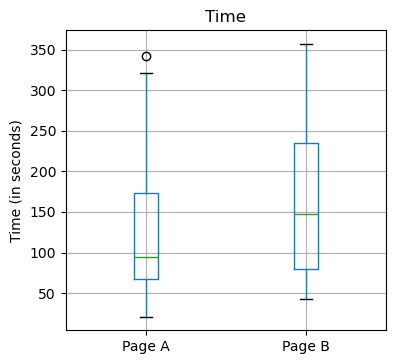

In [6]:
ax = session_times.boxplot(by="Page", column="Time", figsize=(4, 4))
ax.set_xlabel("")
ax.set_ylabel("Time (in seconds)")
plt.suptitle("")

plt.show()

In [7]:
mean_a = session_times[session_times.Page == "Page A"].Time.mean()
mean_b = session_times[session_times.Page == "Page B"].Time.mean()
mean_b - mean_a

35.66666666666667

In [10]:
def perm(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B

    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()

nA = session_times[session_times.Page == "Page A"].shape[0]
nB = session_times[session_times.Page == "Page B"].shape[0]

perm(session_times.Time, nA, nB)

-78.61904761904763

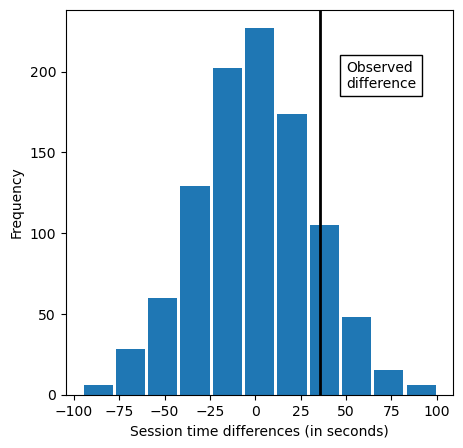

In [11]:
random.seed(1)
perm_diffs = [perm(session_times.Time, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color="black", lw=2)
ax.text(50, 190, "Observed\ndifference", bbox={"facecolor": "white"})
ax.set_xlabel("Session time differences (in seconds)")
ax.set_ylabel("Frequency")

plt.show()

In [12]:
perm_diffs = np.array(perm_diffs)
np.mean(perm_diffs > mean_b - mean_a)

0.121

# Статистическая значимость и p-значения

Observed difference: 0.0368%


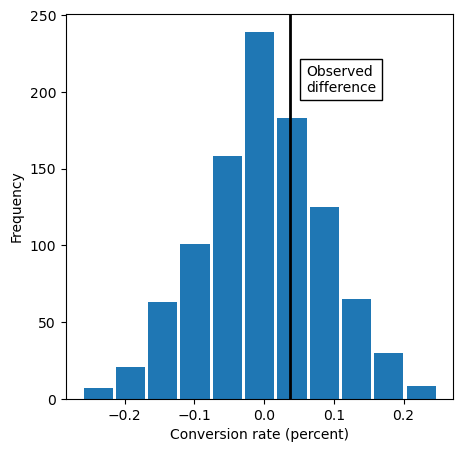

In [14]:
random.seed(1)
obc_pct_diff = 100 * (200 / 23739 - 182 / 22588)

print(f"Observed difference: {obc_pct_diff:.4f}%")

conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)

perm_diffs = [
    100 * perm(conversion, 23739, 22588) for _ in range(1000)
]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obc_pct_diff, color="black", lw=2)
ax.text(0.06, 200, "Observed\ndifference", bbox={"facecolor": "white"})
ax.set_xlabel("Conversion rate (percent)")
ax.set_ylabel("Frequency")

plt.show()

# P-значение

Если np.mean применяется к списку логических значений, он дает процент того, как часто True встречалось в списке (#True / #Total).

In [15]:
np.mean([diff > obc_pct_diff for diff in perm_diffs])

0.332

In [16]:
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])

chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f"p-значение для одностороннего теста: {p_value / 2:.4f}")

p-значение для одностороннего теста: 0.3498


# t-тесты

In [17]:
res = stats.ttest_ind(session_times[session_times.Page == "Page A"].Time,
                      session_times[session_times.Page == "Page B"].Time,
                      equal_var=False)

print(f"p-значение для одностороннего теста: {res.pvalue / 2:.4f}")

p-значение для одностороннего теста: 0.1408


In [18]:
tstat, pvalue, df = sm.stats.ttest_ind(
    session_times[session_times.Page == "Page A"].Time,
    session_times[session_times.Page == "Page B"].Time,
    usevar="unequal", alternative="smaller",
)

print(f"p-значение: {pvalue:.4f}")

p-значение: 0.1408


# ANOVA

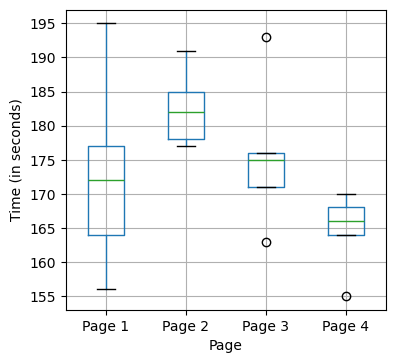

In [19]:
four_sessions = pd.read_csv(FOUR_SESSIONS_CSV)

ax = four_sessions.boxplot(by="Page", column="Time", figsize=(4, 4))

ax.set_xlabel("Page")
ax.set_ylabel("Time (in seconds)")
plt.suptitle("")
plt.title("")

plt.show()

In [20]:
pd.read_csv(FOUR_SESSIONS_CSV).head()

,Page,Time
0,Page 1,164
1,Page 2,178
2,Page 3,175
3,Page 4,155
4,Page 1,172


In [24]:
observed_variance = four_sessions.groupby("Page").mean().var().iloc[0]
print("Observed means:", four_sessions.groupby("Page").mean().values.ravel())
print("Variance:", observed_variance)

def perm_test(df):
    df = df.copy()
    df["Time"] = np.random.permutation(df["Time"].values)
    return df.groupby("Page").mean().var().iloc[0]

perm_test(four_sessions)

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655


53.26666666666663

Pr(Prob) 0.07966666666666666


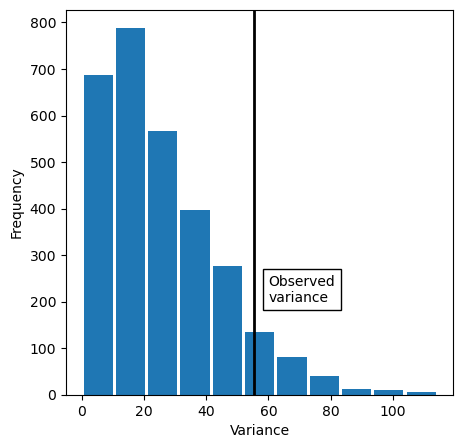

In [25]:
random.seed(1)
perm_variance = [perm_test(four_sessions) for _ in range(3000)]

print("Pr(Prob)", np.mean([var > observed_variance for var in perm_variance]))

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_variance, bins=11, rwidth=0.9)
ax.axvline(x = observed_variance, color="black", lw=2)
ax.text(60, 200, "Observed\nvariance", bbox={"facecolor": "white"})
ax.set_xlabel("Variance")
ax.set_ylabel("Frequency")

plt.show()

# F-статистика

Мы можем вычислить таблицу ANOVA с помощью statsmodel.

In [26]:
model = smf.ols("Time ~ Page", data=four_sessions).fit()

aov_table = sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
Page,3.0,831.4,277.133333,2.739825,0.077586
Residual,16.0,1618.4,101.150000,NaN,NaN


In [27]:
res = stats.f_oneway(
    four_sessions[four_sessions.Page == "Page 1"].Time,
    four_sessions[four_sessions.Page == "Page 2"].Time,
    four_sessions[four_sessions.Page == "Page 3"].Time,
    four_sessions[four_sessions.Page == "Page 4"].Time,
)

print(f"F-статистика: {res.statistic / 2:.4f}")
print(f"p-значение: {res.pvalue / 2:.4f}")

F-статистика: 1.3699
p-значение: 0.0388


# Двухфакторный дисперсионный анализ доступен только с statsmodels

### formula = 'len ~ C(supp) + C(dose) + C(supp):C(dose)' 
### model = ols(formula, data).fit()
### aov_table = anova_lm(model, typ=2)

# Хи-квадрат. Проверка на основе повтороного отбора

In [28]:
click_rate = pd.read_csv(CLICK_RATE_CSV)
clicks = click_rate.pivot(index="Click", columns="Headline", values="Rate")
clicks

Headline,Headline A,Headline B,Headline C
Click,,,
Click,14,8,12
No-click,986,992,988
